In [1]:
# default_exp core

In [2]:
import sys
!conda install --yes --prefix {sys.prefix} -c fastai nbdev

Solving environment: done

## Package Plan ##

  environment location: /Users/ilovepenguinsalot/anaconda3/envs/dialog_act_hierarchy

  added / updated specs:
    - nbdev


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.10.26 |       hecd8cb5_2         115 KB
    certifi-2021.10.8          |   py38hecd8cb5_0         151 KB
    openssl-1.1.1l             |       h9ed2024_0         2.2 MB
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2021.5.3~ --> pkgs/main::ca-certificates-2021.10.26-hecd8cb5_2
  certifi            conda-forge::certifi-2021.5.30-py38h5~ --> pkgs/main::certifi-2021.10.8-py38hecd8cb5_0
  openssl            conda-forge::openssl-1.1.1k-h0d85af4_0 --> pkgs/main::openssl-1.1.1l-h9ed20

# SGNN

> Implementation of Self-Governing Neural Networks for speech act classification

## Implementation of the [SGNN paper](https://www.aclweb.org/anthology/D19-1402.pdf) for speech act classification.
This repository is inspired by Guillaume Chevalier's [implementation](https://github.com/guillaume-chevalier/SGNN-Self-Governing-Neural-Networks-Projection-Layer), as well as his [discussion](https://github.com/guillaume-chevalier/SGNN-Self-Governing-Neural-Networks-Projection-Layer/issues/1) with [Sava Kalbachou](https://github.com/thinline).
This version implements some things differently from Guillaume's code, in an attempt to resemble the paper more, and extends beyond the projection layer all the way to a fully trainable network.

The network is trained to classify the [SwDA corpus](https://web.stanford.edu/~jurafsky/ws97/) utterances according to their speech act. The corpus was was pre-processed using Cristopher Pott's [project](https://github.com/cgpotts/swda/) related to it. To follow Lee & Dernoncourt SwDA data split, as in the SGNN paper, we added [adequate functionality](https://github.com/glicerico/swda/blob/data_split/create_sets.py) in our [branch](https://github.com/glicerico/swda/tree/data_split) of that repo. The pre-processed data is included in the [`data`](data) folder for repeateability.

In [1]:
#hide
from nbdev.showdoc import *

In [2]:
import sys
!conda install --yes --prefix {sys.prefix} -c condaforge tensorflow


UnavailableInvalidChannel: The channel is not accessible or is invalid.
  channel name: condaforge
  channel url: https://conda.anaconda.org/condaforge
  error code: 404

You will need to adjust your conda configuration to proceed.
Use `conda config --show channels` to view your configuration's current state,
and use `conda config --show-sources` to view config file locations.




## Required modules

In [1]:
#export
import functools
import random as rand
import re

from livelossplot import PlotLossesKerasTF
from nearpy.hashes import RandomBinaryProjections
from nltk.util import skipgrams
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow.keras as keras

## Import data from file

In [2]:
#export
def import_data(filepath):
    """
    Imports data from file and removes empty entries
    :param filepath:  Path to file with SwDa utterances in format "ActTag,Text"
    :return:          pandas dataframe with the data
    """
    data = pd.read_csv(filepath)
    data = data.dropna(axis=0)  # Drop rows with NA values
    
    return data
    

## Preprocess data, and divide it in train, validation and test sets

In [3]:
#export    
def preprocess_data(data, lowercase=False, clean=False, remove_continuations=True):
    """
    Preprocess the data according to parameters. 
    Divides the data into training, validation and test sets.
    
    :param data:  Pandas dataframe imported by `import_data`
    Optional:
    :param lowercase:  Convert all text to lowercase
    :param clean:  Remove punctuation marks and non-verbal utterances
    :param remove_continuations:  Remove utterances with act tag "+"
    
    :return:  Pandas series with training, validation and test tags and utterances
    """
    if lowercase:
        data['Text'] = data['Text'].str.lower()
    if clean:
        # Remove punctuation
        data['Text'] = [re.sub('[(|)|#|.]', '', line) for line in data['Text']]
        # Remove dashes and words in angle brackets (e.g. "<Laughter>")
        data['Text'] = [re.sub('\W-+\W|<\w+>', ' ', line) for line in data['Text']]
    if remove_continuations:
        data = data[~(data.DamslActTag == '+')]
    
    # Remove extra spaces
    data['Text'] = [re.sub('\s+', ' ', line) for line in data['Text']]
    data = data[~(data.Text == ' ')]  # Remove data rows that end up empty after cleaning
                            
    X, y = data.Text, data.DamslActTag
    print(data.DamslActTag.unique())
                            
    return X, y


## Transform RandomBinaryProjections to transformer

In [4]:
#export
class Transformer_RBP(BaseEstimator, RandomBinaryProjections):
    """
    Class that modifies RandomBinaryProjections to use as an sklearn transformer
    """
    rand_seed = None  # Declare it as class variable
    def __init__(self, hash_name='hasher', projection_count=1, rand_seed=None):
        RandomBinaryProjections.__init__(self, hash_name, projection_count, rand_seed=rand_seed)
        
    def fit(self, X, y):
        self.rand = np.random.RandomState(self.rand_seed)  # rand seed after param setting
        self.reset(X.shape[1])
        
    def transform(self, X):
        return self.hash_vector(X)

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)
    
    def hash_vector(self, v, querying=False):
        """
        Hashes the vector and returns the binary bucket key as string.
        """
        if sp.issparse(v):
            # If vector is sparse, make sure we have the CSR representation
            # of the projection matrix
            if self.normals_csr is None:
                self.normals_csr = sp.csr_matrix(self.normals)
            # Make sure that we are using CSR format for multiplication
            if not sp.isspmatrix_csr(v):
                v = sp.csr_matrix(v)
            # Project vector onto all hyperplane normals
            # projection = self.normals_csr.dot(v)
            projection = v.dot(sp.csr_matrix.transpose(self.normals_csr))
        else:
            # Project vector onto all hyperplane normals
            projection = np.dot(v, np.matrix.transpose(self.normals))
        # Return binary key
        return projection > 0
    

## Create input layer projections
This is the main contribution of the SGNN paper, and the implementation is inspired by Guillaume Chevalier's [implementation](https://github.com/guillaume-chevalier/SGNN-Self-Governing-Neural-Networks-Projection-Layer), as well as his [discussion](https://github.com/guillaume-chevalier/SGNN-Self-Governing-Neural-Networks-Projection-Layer/issues/1) with [Sava Kalbachou](https://github.com/thinline).

In [5]:
#export
def build_input_layer(T=80, d=14):
    """
    Transformer to build the input layer, in SGNN style.
    Uses nltk skipgrams, and several Transformer_RBP layers as elements of the SGNN pipeline.
    """
    # T=80 projections for each of dimension d=14: 80 * 14 = 1120-dimensionnal word projections

    # Wrap skipgrams to use with CountVectorizer
    skipper = functools.partial(skipgrams, n=3, k=2) # 2-skip-3-grams
    # CountVectorizer params
    char_term_frequency_params = {
        'char_term_frequency__analyzer': skipper,
        'char_term_frequency__min_df': 3,
        'char_term_frequency__max_df': 0.9,
        'char_term_frequency__max_features': int(1e7),
    }

    # Transformer_RBP params
    rand_seeds = [rand.randint(0, T*100) for i in range(T)] # Need a different repeatable seed for each hasher
    hashing_feature_union_params = {
        **{'union__random_binary_projection_hasher_{}__projection_count'.format(t): d
           for t in range(T)
        },
        **{'union__random_binary_projection_hasher_{}__hash_name'.format(t): 'hasher' + str(t)
           for t in range(T)
        },
        **{'union__random_binary_projection_hasher_{}__rand_seed'.format(t): rand_seeds[t]  # only AFTER hashing.
           for t in range(T)
        }
    }

    # Pipeline to create input layer
    preprocessor = Pipeline([
        ("char_term_frequency", CountVectorizer()),
        ('union', FeatureUnion([
            ('random_binary_projection_hasher_{}'.format(t), Transformer_RBP())
            for t in range(T)
        ]))
    ])
    
    params = dict()
    params.update(char_term_frequency_params)
    params.update(hashing_feature_union_params)
    preprocessor.set_params(**params)
    return preprocessor


## Create keras model
Following the SGNN paper's architecture

In [6]:
#export
def build_keras_model(train_labels):
    """
    Build keras model, with two hidden layers as the SGNN paper.
    """
    model = keras.Sequential()
#     model.add(keras.layers.Dropout(0.25, input_shape=(1120,)))
#     model.add(keras.layers.Dense(256, activation=tf.nn.relu))
    model.add(keras.layers.Dense(256, activation=tf.nn.sigmoid, input_shape=(1120,)))
    model.add(keras.layers.Dropout(0.25))
#     model.add(keras.layers.Dense(256, activation=tf.nn.relu))
#     model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(256, activation=tf.nn.sigmoid))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(train_labels.shape[1], activation=tf.nn.softmax))

    # Cosine annealing decay
    lr_schedule = keras.experimental.CosineDecay(0.025, decay_steps=20000)
    # SGD optimizer with Nesterov momentum
    opt = keras.optimizers.SGD(nesterov=True, learning_rate=lr_schedule)
#     opt = keras.optimizers.SGD(nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['categorical_accuracy'])

    return model


In [7]:
import matplotlib.pyplot as plt

def generate_and_print_confusion_matrix(keras_model, test_features, y_test, le):
    pred_labels = keras_model.predict(test_features)
    pred_cat_labels = le.inverse_transform(pred_labels.argmax(axis=1))
    print(pred_cat_labels)
    
    test_cat_labels = le.inverse_transform(y_test)
    matrix = confusion_matrix(test_cat_labels, pred_cat_labels)
    print(matrix)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    plt.title('Confusion Matrix')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    

## Main process, putting together previous functions

In [8]:
#export
#EPOCHS = 1
EPOCHS = 1000
#BATCH_SIZE = 10
BATCH_SIZE = 100
LOWERCASE=True
CLEAN=True
REMOVE_CONTINUATIONS=True
REPO_PATH = "/Users/ilovepenguinsalot/ResearchProjects/AtypicalDialogAnalysis/SGNN/"

In [9]:
# Set constants
REPO_PATH="/Users/ilovepenguinsalot/ResearchProjects/AtypicalDialogAnalysis/SGNN/"
TRAIN_FILEPATH = REPO_PATH + "data/train-acttags-and-text.csv"
VALID_FILEPATH = REPO_PATH + "data/valid-acttags-and-text.csv"
TEST_FILEPATH = REPO_PATH+ "data/test-acttags-and-text.csv"
PREDICT_FILEPATH = REPO_PATH + "data/sgnn_format_test.xlsx"

In [10]:
def preprocess_prediction_files(data, lowercase, clean, remove_continuations):
    """
    Preprocess the data according to parameters. 
    Divides the data into training, validation and test sets.
    
    :param data:  Pandas dataframe imported by `import_data`
    Optional:
    :param lowercase:  Convert all text to lowercase
    :param clean:  Remove punctuation marks and non-verbal utterances
    :param remove_continuations:  Remove utterances with act tag "+"
    
    :return:  Pandas series with training, validation and test tags and utterances
    """
    if lowercase:
        data['Text'] = data['Text'].str.lower()
    if clean:
        # Remove punctuation
        data['Text'] = [re.sub('[(|)|#|.]', '', line) for line in data['Text']]
        # Remove dashes and words in angle brackets (e.g. "<Laughter>")
        data['Text'] = [re.sub('\W-+\W|<\w+>', ' ', line) for line in data['Text']]
    
    # Remove extra spaces
    data['Text'] = [re.sub('\s+', ' ', line) for line in data['Text']]
    data = data[~(data.Text == ' ')]  # Remove data rows that end up empty after cleaning
    
    return data.Text       

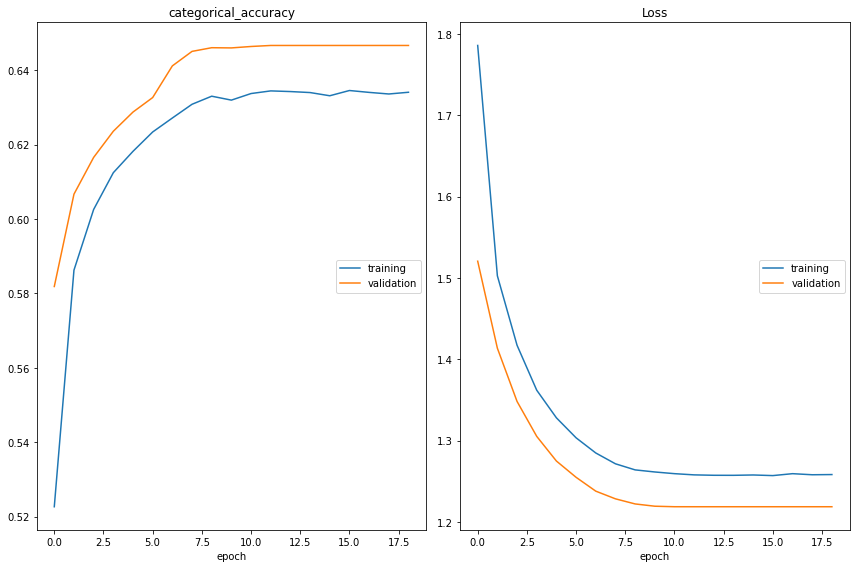

categorical_accuracy
	training         	 (min:    0.523, max:    0.635, cur:    0.634)
	validation       	 (min:    0.582, max:    0.647, cur:    0.647)
Loss
	training         	 (min:    1.257, max:    1.786, cur:    1.258)
	validation       	 (min:    1.219, max:    1.520, cur:    1.219)
Evaluating the keras model
128/128 [==============================] - 1s 7ms/step - loss: 1.2997 - categorical_accuracy: 0.5951
['b' 'b' 'sd' ... 'sd' 'sd' 'sd']
[[ 260    0    0 ...   54    0    0]
 [   1    0    0 ...   17    0    0]
 [   1    0    0 ...    6    0    0]
 ...
 [  20    0    0 ... 1272   13    0]
 [  13    0    0 ...  654   33    0]
 [   0    0    0 ...    1    0    0]]
name 'labels' is not defined
Error generating confusion matrix, moving on.


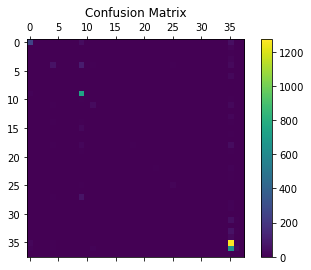

In [11]:
# Train the model on Swtichboard
data_train = import_data(TRAIN_FILEPATH)
data_valid = import_data(VALID_FILEPATH)
data_test = import_data(TEST_FILEPATH)
X_train, y_train = preprocess_data(data_train, lowercase=LOWERCASE, clean=CLEAN,
                                           remove_continuations=REMOVE_CONTINUATIONS)
X_valid, y_valid = preprocess_data(data_valid, lowercase=LOWERCASE, clean=CLEAN,
                                           remove_continuations=REMOVE_CONTINUATIONS)
X_test, y_test = preprocess_data(data_test, lowercase=LOWERCASE, clean=CLEAN,
                                           remove_continuations=REMOVE_CONTINUATIONS)
# Convert labels to categories
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)
y_test = le.transform(y_test)
    
# Convert categories to one-hot-encodings, as needed by keras
train_labels = keras.utils.to_categorical(y_train, num_classes=42)
valid_labels = keras.utils.to_categorical(y_valid, num_classes=42)
test_labels = keras.utils.to_categorical(y_test, num_classes=42)
print(test_labels.shape)
print(train_labels.shape)
    
    
# Pass text sets through input layer
input_layer = build_input_layer()
train_features = input_layer.fit_transform(X_train)
valid_features = input_layer.transform(X_valid)
test_features = input_layer.transform(X_test)
    
# Define EarlyStopping and loss visualization
keras_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, 
                                                        restore_best_weights=True),
                       PlotLossesKerasTF()]
print("Fit and evaluate NN.")
# Fit and evaluate NN
keras_model = build_keras_model(train_labels)
keras_model.fit(train_features, train_labels, epochs=EPOCHS, 
                batch_size=BATCH_SIZE, shuffle=True,
                validation_data=(valid_features, valid_labels),
                callbacks=keras_callbacks
                )    

# Print the confusion matrix for the Keras model
print("Evaluating the keras model")
keras_model.evaluate(test_features, test_labels)

try:
    generate_and_print_confusion_matrix(keras_model, test_features, y_test, le)
except Exception as e:
    print(e)
    print("Error generating confusion matrix, moving on.")    

In [12]:
# serialize model to JSON
model_json = keras_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
keras_model.save_weights("model.h5")
print("Saved model to disk")


Saved model to disk


In [13]:
from keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(test_features, test_labels, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 59.51%


In [ ]:
# Run the prediction on the prediction filepath file
# Convert the sentences to the appropriate features based on our input layer
prediction_df = pd.read_csv(PREDICT_FILEPATH)
clean_prediction_df = preprocess_prediction_files(prediction_df, LOWERCASE, CLEAN, REMOVE_CONTINUATIONS)
print(clean_prediction_df[0])
prediction_features = input_layer.transform(clean_prediction_df)
print(prediction_features[0])
results = keras_model.predict_classes(prediction_features)
print(results)

In [28]:
pred_cat_labels = le.inverse_transform(results)
pred_cat_labels

array(['sd', 'sd', 'sd', 'b', 'sd', 'sd', 'sv', 'b', 'sv', 'b', 'sd', 'b',
       'sd', 'sd', 'b', 'sd', 'sd', 'sd', 'sd', 'sd', 'sd', 'sd', 'b',
       'sd', 'sd', '%', 'b', 'sd', 'b', 'sd', 'b', 'sd', 'sd', 'sd', 'sd',
       'b', 'sd', 'sd', 'sd', 'sd', 'sd', 'sd', 'b', 'sd', 'sv', 'sd',
       'sd', 'b', 'b', 'sd', 'sd', 'sd', 'aa', 'b', 'b', 'sd', 'sd', 'b',
       'sd', 'sd', 'sd', 'sd', 'sd', 'b', 'sd', 'sd', 'sd', 'sd', 'sd',
       'b', 'sd', 'sd', 'sd', 'sd', 'sd', 'sd', 'b', 'sd', 'sd', 'b', 'b',
       'b', 'sd', 'b', 'sd', 'sd', 'sd', 'sd', 'qy', 'b', 'sd', 'sv', 'b',
       'aa', 'b', 'sd', 'b', 'aa', 'sd', 'sd', 'sd', 'sd', 'sd', 'sd',
       'qy', 'sd', 'sd', 'sd', 'sd', 'sd', 'sd', 'sd', 'sd', 'sd', 'sd',
       'sd', 'sd', 'ba', 'b', 'sd', 'b', 'b', 'sv', 'sd', 'sd', 'b', 'b',
       'aa', 'sd', 'sd', 'sd', 'b', 'sd', 'sd', 'sd', 'sd', 'b', 'sd',
       'sd', 'sd', 'sd', 'b'], dtype=object)

In [31]:
len(set(le.inverse_transform(y_train)))

42

In [14]:
def convert_cat_label_to_full_damsl_tag(cat_label):
    cat_label_to_damsl_tag_mapping = {'%': 'Uninterpretable',
         '^2': 'Collaborative Completion',
         '^g': 'Tag-Question',
         '^h': 'Hold before answer/agreement',
         '^q': 'Quotation',
         'aa': 'Agree/Accept',
         'aap_am': 'Maybe/Accept-part',
         'ad': 'Action-directive',
         'ar': 'Reject',
         'arp_nd': 'Dispreferred answers',
         'b': 'Acknowledge (Backchannel)',
         'b^m': 'Repeat-phrase',
         'ba': 'Appreciation',
         'bd': 'Downplayer',
         'bf': 'Summarize/reformulate',
         'bh': 'Backchannel in question form',
         'bk': 'Response Acknowledgement',
         'br': 'Signal-non-understanding',
         'fa': 'Apology',
         'fc': 'Conventional-closing',
         'fo_o_fw_"_by_bc': 'Other',
         'fp': 'Conventional-opening',
         'ft': 'Thanking',
         'h': 'Hedge',
         'na': 'Affirmative non-yes answers',
         'ng': 'Negative non-no answers',
         'nn': 'No answers',
         'no': 'Other answers',
         'ny': 'Yes answers',
         'oo_co_cc': 'Offers, Options Commits',
         'qh': 'Rhetorical-Questions',
         'qo': 'Open-Question',
         'qrr': 'Or-Clause',
         'qw': 'Wh-Question',
         'qw^d': 'Declarative Wh-Question',
         'qy': 'Yes-No-Question',
         'qy^d': 'Declarative Yes-No-Question',
         'sd': 'Statement-non-opinion',
         'sv': 'Statement-opinion',
         't1': 'Self-talk',
         't3': '3rd-party-talk',
         'x': 'Non-verbal'}
    return cat_label_to_damsl_tag_mapping[cat_label]

In [6]:
convert_cat_label_to_full_damsl_tag('x')

'Non-verbal'

In [18]:
# Merge the original dataframe with the results and write to a file
def write_results_to_file(original_df, results, le, output_file):
    # Convert the predicted numeric labels back to their dialog act result and then combine them with the original text
    pred_cat_labels = le.inverse_transform(results)
    dialog_acts = [convert_cat_label_to_full_damsl_tag(c) for c in pred_cat_labels]
    
    dialog_act_df = pd.DataFrame(dialog_acts, columns=['DialogAct'])
    result_df = pd.DataFrame(pred_cat_labels, columns=['DAMSLTag'])
    data = [original_df, result_df, dialog_act_df]
    
    # Figure out headers situation
    #headers = ["Text", "DialogAct"]
    output_df = pd.concat(data, axis=1)
    output_df.to_excel(output_file)
    print(f"Successful written output data to file: {output_file}.")

In [8]:
OUTPUT_FILE = "data/output/sgnn_test_talkmoves.xlsx"
write_results_to_file(prediction_df, results, le, OUTPUT_FILE)

NameError: name 'prediction_df' is not defined

In [22]:
import os

# For a single file:
# 1. Convert the talkmove file to a dataframe and preprocess for use with the SGNN system
# 2. Run through the input layer to get a feature vector
# 3. Predict classes with the Keras Model
# 4. Merge the result DF with the original DF
# 5. Write the result DF to a file
def predict_for_talkmove_file(talkmove_file, output_file, keras_model, le, lowercase, clean, remove_continuations):
    # Read CSV into a dataframe
    original_df = pd.read_excel(talkmove_file, header=0, engine='openpyxl')
    
    # Preprocess DF to have in SGNN format
    sgnn_format_df = original_df['Sentence'].to_frame().rename(columns={"Sentence": "Text"})
    clean_prediction_df = preprocess_prediction_files(sgnn_format_df, lowercase, clean, remove_continuations)
    prediction_features = input_layer.transform(clean_prediction_df)
    
    # Predict with the keras model
    results = keras_model.predict_classes(prediction_features)
    
    # Write results to file
    write_results_to_file(original_df, results, le, output_file)
    
def predict_for_all_talkmoves_files(talkmoves_dir, output_dir, keras_model, le, lowercase, clean, remove_continuations):
    transcript_count = 0
    errors = 0
    for root, dirs, files in os.walk(talkmoves_dir):
        for file in files:
            if file.endswith('.xlsx'):
                try:
                    transcript_filepath = os.path.join(root, file)
                    new_filename = f"{file}_with_dialog_acts.xlsx"
                    output_filepath = f"{output_dir}/{new_filename}"
                    predict_for_talkmove_file(transcript_filepath, output_filepath, keras_model, le, lowercase, clean, remove_continuations)
                    print("Success")
                    transcript_count +=1 
                except Exception as e:
                    print(f"{transcript_filepath} has an error: {e}")
                    errors +=1
    print(f"Files annotated with dialog acts: {transcript_count}. Transcription errors : {errors}.")

In [20]:
# Test joint function with a single file
# TODO: Update values
TEST_FILE = 'data/7th_grade_math.xlsx'
OUTPUT_FILE = "data/output/sgnn_test_talkmoves2.xlsx"
predict_for_talkmove_file(TEST_FILE, OUTPUT_FILE, loaded_model, le, LOWERCASE, CLEAN, REMOVE_CONTINUATIONS)

Successful written output data to file: data/output/sgnn_test_talkmoves2.xlsx.


In [23]:
# Annotate all Talk Moves files with dialogue acts from the SGNN model
# TODO: update values
TRANSCRIPT_DIR_1 = "/Users/ilovepenguinsalot/ResearchProjects/TalkMoves/data/Subset 1"
TRANSCRIPT_DIR_2 = "/Users/ilovepenguinsalot/ResearchProjects/TalkMoves/data/Subset 2"
output_dir_1 = "data/output1"
output_dir_2 = "data/output2"
predict_for_all_talkmoves_files(TRANSCRIPT_DIR_1, output_dir_1, loaded_model, le, LOWERCASE, CLEAN, REMOVE_CONTINUATIONS)
predict_for_all_talkmoves_files(TRANSCRIPT_DIR_2, output_dir_2, loaded_model, le, LOWERCASE, CLEAN, REMOVE_CONTINUATIONS)

Successful written output data to file: data/output1/Math US2 transcript(1).xlsx_with_dialog_acts.xlsx.
Success
Successful written output data to file: data/output1/Video Mosaic Grade 4 Infinite Number Line 2.xlsx_with_dialog_acts.xlsx.
Success
Successful written output data to file: data/output1/Math NL2 transcript.xlsx_with_dialog_acts.xlsx.
Success
Successful written output data to file: data/output1/Martino Fraction Equivalence 2_Grade 4.xlsx_with_dialog_acts.xlsx.
Success
Successful written output data to file: data/output1/What is one half 3_grade 4.xlsx_with_dialog_acts.xlsx.
Success
Successful written output data to file: data/output1/Math CZ4 transcript.xlsx_with_dialog_acts.xlsx.
Success
Successful written output data to file: data/output1/Video Mosiac 11th grade World Series 2.xlsx_with_dialog_acts.xlsx.
Success
Successful written output data to file: data/output1/Mosaic Grade 4 Division of Fractions 2.xlsx_with_dialog_acts.xlsx.
Success
Successful written output data to fil